# 4. Tutorial: Create iML1515 GECKO with manually adjusted turnover numbers

In the previous tutorial we created a GECKO model of iML1515 with TurNuP predicted turnover numbers for metabolic reactions in a few simple steps. The model predictions of protein concentrations are still not satisfactory, e.g. the model predicts high protein concentrations where the measured values are very low and vice versa. 

To achieve high prediction quality, a GECKO must be constructed using apparent turnover numbers that account for *in vivo* conditions such as enzyme regulation, enzyme saturation, and substrate channeling (Araiza-Olivera et al., 2013). TurNuP predicted turnover numbers can only give approximate values. The deviation between predicted and measured data is estimated to be a factor of 4.8. Furthermore, the quality of the training data is poor, consisting mainly of *in vitro* measurements using enzymatic assays. Measurement points are scarce, highly noisy, and acquired in a non-standardized manner using enzyme-specific assay protocols.

Compared to enzymatic assays, quantitative proteomics is a fairly standardized procedure with almost complete protein coverage. This justifies the use of quantitative proteomics to adjust predicted turnover numbers to apparent turnover numbers, as required for the GECKO model. 

In this tutorial, we attempt to improve protein predictions by selectively adjusting turnover numbers. This requires a more detailed analysis of the optimization results combined with a certain amount of organism specific knowledge. We will analyze predicted flux distributions and try to redirect fluxes to physiologically relevant pathways. We will selectively compare predicted to measured protein levels and adjust GECKO coupling factors by modifying turnover numbers. Our focus will be on the major carbon metabolism. The methods and code snippets provided can be used to adjust other parts of the model as well.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025

## Step 1: Initial setup

In [1]:
# Required imports and model names
import os
import re
import pandas as pd
import cobra

from f2xba import XbaModel, EcModel
from f2xba import EcmOptimization, EcmResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
baseline_model = 'iML1515_predicted_GECKO'
target_model = 'iML1515_manual_adjust_GECKO'
reference_cond = 'Glucose'
        
# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr )in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Analyze baseline GECKO model (cobrapy)

First, we need to identify deficiencies in our baseline GECKO model. Using Escher maps, we can visualize predicted flux distributions. By applying organism specific knowledge and comparing predicted to measured protein levels, we can visually identify pathways and reactions where predictions appear to be incorrect. Our focus will be on the major carbon metabolism for the glucose medium, the chosen reference condition.

In [2]:
# Load model using cobrapy
fname = os.path.join('SBML_models', f'{baseline_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
all_genes = set(eo.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = eo.get_tx_metab_genes()
print(f'total modeled protein: {total_protein:.2f} mg/gDW, enzyme saturation level: {sigma}')
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-22
SBML model loaded by sbmlxdf: SBML_models/iML1515_predicted_GECKO.xml (Thu Mar 20 20:53:54 2025)
total modeled protein: 306.59 mg/gDW, enzyme saturation level: 0.64
1494 genes: (492) transporter, (1002) metabolic


Acetate                  : pred gr: 0.439 h-1 vs. exp 0.290, diff:  0.149
Glycerol                 : pred gr: 0.669 h-1 vs. exp 0.470, diff:  0.199
Fructose                 : pred gr: 0.625 h-1 vs. exp 0.540, diff:  0.085
L-Malate                 : pred gr: 0.738 h-1 vs. exp 0.550, diff:  0.188
Glucose                  : pred gr: 0.658 h-1 vs. exp 0.660, diff: -0.002
Glucose 6-Phosphate      : pred gr: 0.735 h-1 vs. exp 0.780, diff: -0.045


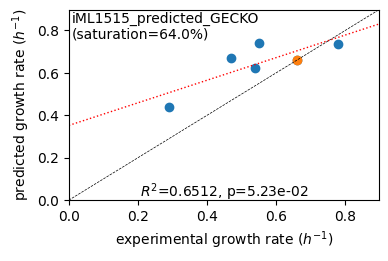

Protein mass fractions:
Acetate                  : r² = 0.0335, p = 5.77e-09 ( 999 proteins lin scale)
Glycerol                 : r² = 0.0393, p = 2.64e-10 ( 999 proteins lin scale)
Fructose                 : r² = 0.0973, p = 5.46e-24 ( 999 proteins lin scale)
Glucose                  : r² = 0.0733, p = 3.07e-18 ( 999 proteins lin scale)
Acetate                  : r² = 0.2763, p = 3.27e-23 ( 307 proteins log scale)
Glycerol                 : r² = 0.2500, p = 9.31e-21 ( 306 proteins log scale)
Fructose                 : r² = 0.2748, p = 2.69e-22 ( 296 proteins log scale)
Glucose                  : r² = 0.2841, p = 7.38e-24 ( 306 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 537.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 471.4 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 308.0 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 163.3 mg/gP predicted
      49

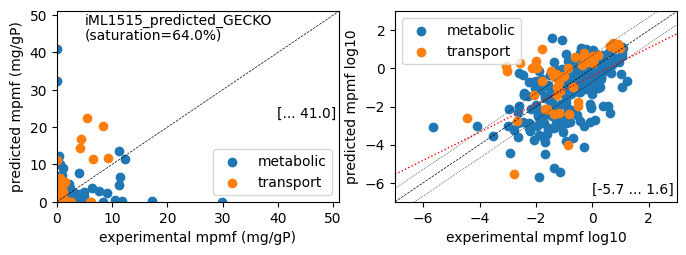

1 file(s) exported for "Load reaction data" into Escher maps


In [3]:
# Optimize model using cobrapy and extract results
pred_results = {}
for cond, medium in conditions.items():
    with ecm as model:    
        model.medium = medium 
        solution = model.optimize()
        if solution.status == 'optimal':
            gr = solution.objective_value
            pred_results[cond] = solution
            print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
                  f'diff: {gr - exp_grs[cond]:6.3f}')
        else:    
            print(f'{cond} ended with status {solution.status}')

# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight=reference_cond)
print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels(reference_cond)
er.plot_proteins(reference_cond)  
er.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))

### check outliers in protein correlation

The presence of issues in the model parametrization can be identified through a visual examination of protein correlation plots in both linear and log scale. Data points suspected of having issues should be queried and subsequently analyzed in detail.

In [4]:
# proteins from linear protein correlation plot with poor predictions
for gene, pred in df_proteins[reference_cond].to_dict().items():
    if gene in df_mpmf.index:
        exp = df_mpmf.at[gene, reference_cond]
        if (exp < 1 and pred > 10) or (exp > 10 and pred < 1):
            description = df_proteins.at[gene, 'description']
            gname = df_proteins.at[gene, 'gene_name']
            print(f'{gene} pred {pred:8.4f} vs. {exp:8.4f}; {gname}: {description}')

b3389 pred  32.3040 vs.   0.0809; aroB: 3-dehydroquinate synthase
b1851 pred  41.0106 vs.   0.0359; edd: Phosphogluconate dehydratase
b1276 pred  12.2569 vs.   0.3967; acnA: Aconitate hydratase 1
b3737 pred  11.1340 vs.   0.0161; atpE: ATP synthase subunit c
b3256 pred  10.1240 vs.   0.6090; accC: Biotin carboxylase
b1136 pred   0.4961 vs.  10.5086; icd: Isocitrate dehydrogenase [NADP]
b2414 pred   0.2211 vs.  17.2441; cysK: Cysteine synthase A
b3236 pred   0.1043 vs.  11.7189; mdh: Malate dehydrogenase
b3829 pred   0.0000 vs.  29.7986; metE: 5-methyltetrahydropteroyltriglutamate--homocysteine methyltransferase


### query results records of interest

The supplementary information columns present in the optimization results tables are useful for filtering records of interest. 

In [5]:
# check reactions catalyzed by a given gene product
df_net_fluxes[df_net_fluxes['gpr'].str.contains('b1851')]

,reaction_str,gpr,rank,mean mmol_per_gDWh,abs_mean mmol_per_gDWh,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
rid,,,,,,,,,,,,
EDD,6pgc_c => 2ddg6p_c + h2o_c,b1851,43,4.371429,4.371429,4.939228,0.0,0.0,6.669039,0.0,10.440232,9.119301


### visualize flux distribution on Escher maps

The predicted flux values were exported in the ‘.json’ format using the command `er.save_to_escher()`. Given the central carbon metabolism focal point, the subsequent step involves accessing the Escher web portal (https://escher.github.io), loading the map designated 'Central Metabolism (iJO1366)', and selecting 'Data > Load reaction data' to upload the file named 'iML1515_predicted_GECKO_Glucose_reaction_data.json' under '.\data' (Data > Load reaction data).

A visual inspection of the flux distribution indicates that the upper glycolytic flux appears to be inadequate, as the majority of imported glucose is directed towards the pentose phosphate pathway (PPP). To address this issue, we will adjust the turnover numbers to shift flux from the PPP to glycolysis. Additionally, we will attempt to enhance the flux distribution within the tricarboxylic acid cycle (TCA).

### query critical reaction fluxes and related proteins. 

Having gained insights into the predicted flux distributions between glycolysis and the pentose phosphate pathway (PPP), we return to the optimization results and query critical reaction fluxes in those pathways and the related proteins. We can observe that the protein encoded by the gene b1852\zwf has a predicted concentration that is higher than the measured concentration by a factor of 7.5. In contrast, the protein encoded by b4025/pgi has a 8-fold lower predicted concentration than measured. The gene products b1723/pfgB and b3916/pgkA are isoenzymes of the PFK reaction, which has been sub-divided into two sub-reactions: PFK_iso1, catalyzed by b1723 with a molecular weight of 32.4 kDa, and PFK_iso2, catalyzed by b3916 (34.8 kDa). As their predicted turnover numbers are similar (13.37 and 13.34 $s^{-1}$, respectively), GECKO selects the sub-reaction PFK_iso1, due to its lower molecular weight. However, proteomics data and literature (see BioCyc entries for these genes) suggest that b3916/pgkA is the preferred protein. The FBA reaction is catalyzed by the isoenzymes b2097/fbaA and b2925/fbaB, and the predicted flux should be carried by the sub-reaction catalyzed by b2925/fbaA.

In [6]:
# analyze flux split upper glycolysis and PPP
rids = ['G6PDH2r', 'EDA', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK']

rid2genes = {}
for rid in rids:
    gpr = df_net_fluxes.at[rid, 'gpr']
    print(f'{rid:15s}: {df_net_fluxes.at[rid, reference_cond]:8.3f} mmol/gDWh [{gpr}]')
    rid2genes[rid] = re.findall('b\d{4}', gpr )
    
for rid, genes in rid2genes.items():
    for gene in genes:
        pred = df_proteins[reference_cond].get(gene, 0.0)
        if gene in df_mpmf.index:
            row = df_mpmf.loc[gene]
            exp = row[reference_cond]
            print(f'{rid:10s} {gene} pred: {pred:6.3f} exp: {exp:6.3f} mg/gP  {row["gene_name"]:4s}, '
                  f'{row["mw_Da"]/1000.0:5.1f} kDa, {row["description"][:45]}')
        else:
            print(f'{rid:10s} {gene} pred: {pred:6.3f} exp: not measured')

G6PDH2r        :   10.830 mmol/gDWh [b1852]
EDA            :   10.440 mmol/gDWh [b1850]
PGI            :    0.406 mmol/gDWh [b4025]
PFK            :    0.093 mmol/gDWh [b1723 or b3916]
FBA            :    0.093 mmol/gDWh [b2097 or b2925]
TPI            :    0.000 mmol/gDWh [b3919]
GAPD           :   10.317 mmol/gDWh [b1779]
PGK            :  -10.317 mmol/gDWh [b2926]
PGM            :   -9.185 mmol/gDWh [b0755 or b3612]
ENO            :    9.185 mmol/gDWh [b2779]
PYK            :    0.000 mmol/gDWh [b1676 or b1854]
G6PDH2r    b1852 pred:  3.121 exp:  0.469 mg/gP  zwf ,  55.7 kDa, Glucose-6-phosphate 1-dehydrogenase
EDA        b1850 pred:  3.789 exp:  0.552 mg/gP  eda ,  22.3 kDa, KHG/KDPG aldolase
PGI        b4025 pred:  0.241 exp:  1.931 mg/gP  pgi ,  61.5 kDa, Glucose-6-phosphate isomerase
PFK        b1723 pred:  0.171 exp:  0.208 mg/gP  pfkB,  32.4 kDa, 6-phosphofructokinase isozyme 2
PFK        b3916 pred:  0.000 exp:  0.344 mg/gP  pfkA,  34.8 kDa, 6-phosphofructokinase isozyme 1
FB

## Step 3: Manual adjustment of model parameters

In order to improve protein predictions, we propose a redistribution of traffic flux between glycolysis and PPP. By decreasing the cost of proteins in glycolysis relative to PPP, flux can be redistributed from PPP to glycolysis. This can be achieved by increasing or decreasing the turnover numbers of selected reactions in these pathways. 

First, we assess the impact of different parameter sets in memory. Once we are satisfied, we generate a new GECKO model with the modified parameters. The method of choice for modifying the turnover numbers of selected reactions in memory is EcmOptimize's `eo.scale_kcats()`, which, in fact, updates the coupling factors. The turnover numbers are scaled by a factor provided in a Python dictionary; for example, the factor 2.0 will double the original turnover number. At the termination of the optimization loop, a reversion to the original turnover numbers is facilitated by invoking the function `eo.unscale_kcats()`. Alternatively, when the initial scaling is executed within the context of the cobrapy model (`with ecm as model:`), the reversion to the original values is carried out automatically. Modifications to the turnover numbers affect the predicted growth rates, necessitating adjustments to the average enzyme saturation. This adjustment is achieved indirectly by decreasing the total protein available, utilizing the cobrapy assignment statement `model.reactions.get_by_id('V_PC_total').upper_bound` to establish the upper limit of the variable ‘V_PC_total’ within the model context. The identification of a suitable set of scaling factors that enhance protein predictions is an iterative process, and the resultant set is presented below.

Acetate                  : pred gr: 0.504 h-1 vs. exp 0.290, diff:  0.214
Glycerol                 : pred gr: 0.698 h-1 vs. exp 0.470, diff:  0.228
Fructose                 : pred gr: 0.643 h-1 vs. exp 0.540, diff:  0.103
L-Malate                 : pred gr: 0.690 h-1 vs. exp 0.550, diff:  0.140
Glucose                  : pred gr: 0.654 h-1 vs. exp 0.660, diff: -0.006
Glucose 6-Phosphate      : pred gr: 0.701 h-1 vs. exp 0.780, diff: -0.079


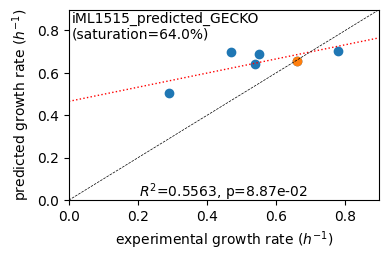

Protein mass fractions:
condition: Glucose
1494 proteins in model with total predicted mass fraction of 445.4 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 425.8 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 256.2 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 169.7 mg/gP predicted
      495 proteins not measured vs.  19.6 mg/gP predicted
           495 actual  proteins      19.6 mg/gP predicted
total           : r² = 0.2060, p = 6.32e-52 ( 999 proteins lin scale)
 metabolic      : r² = 0.2233, p = 1.23e-43 ( 762 proteins lin scale)
 transport      : r² = 0.4381, p = 2.98e-31 ( 237 proteins lin scale)
total           : r² = 0.3458, p = 4.95e-30 ( 308 proteins log scale)
 metabolic      : r² = 0.3798, p = 2.84e-28 ( 257 proteins log scale)
 transport      : r² = 0.3574, p = 3.62e-06 (  51 proteins log scale)


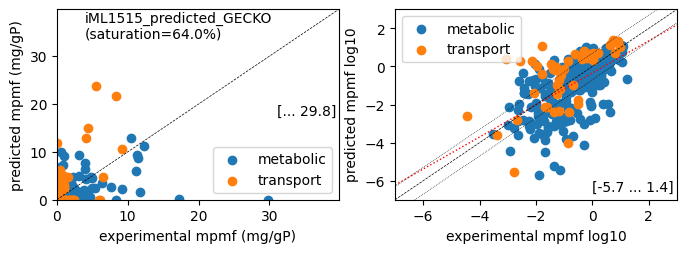

1 file(s) exported for "Load reaction data" into Escher maps


In [7]:
# Optimize model using cobrapy and analyze results with fitted parameters

scale_kcats = {
    # 1. rebalance flux between upper glycolysis and PPP
    'PGI': 2.0, 'PFK_iso2': 20.0, 'FBA_iso2': 10.0, 'TPI': 20.0, 'ENO': 2.0, 'PGM_iso1_REV': 2.0,
    'G6PDH2r': 0.2,
    
    # 2. flux through usage of TCA-cycle
    'PDH': 10.0, 'ACONTa_iso1': 7.0, 'ACONTb_iso1': 7.0,                 
    'ICDHyr': 0.2, 'AKGDH': 8.0, 'SUCOAS_REV': 3.0, 'SUCDi': 8.0, 'MDH': 0.1, 
    
    # 3. fix the low predicted flux for DHQS reaction
    'DHQS': 16.0/0.23,
    } 

# check that scale_kcats dict contains correct reaction ids
for rid in scale_kcats:
    if rid not in eo.rdata:
        print(f'{rid:15s} not found')
        raise ValueError 

# optimization loop
eo.scale_kcats(scale_kcats)
pred_results = {}
for cond, medium in conditions.items():
    with ecm as model:

        new_sat_level = .53
        model.reactions.get_by_id('V_PC_total').upper_bound = total_protein * new_sat_level / sigma

        model.medium = medium 
        solution = model.optimize()
        if solution.status == 'optimal':
            gr = solution.objective_value
            pred_results[cond] = solution
            print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
                  f'diff: {gr - exp_grs[cond]:6.3f}')
        else:    
            print(f'{cond} ended with status {solution.status}')
eo.unscale_kcats()

# results analysis
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight=reference_cond)

print(f'Protein mass fractions:')
er.report_protein_levels(reference_cond)
er.plot_proteins(reference_cond)  
er.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', f'{baseline_model}_adjusted'))

### confirm flux redistribution

The updated turnover numbers have resulted in a significant redistribution of flux from the pentose phosphate pathway (PPP) to glycolysis. Predictions of protein concentration appear to be more accurate when compared to measured protein levels. Furthermore, the selection of correct isoenzymes has been confirmed, as evidenced by the observations of b3916/pfkA and b2925/fbaA.

In [8]:
# analyze flux split upper glycolysis and PPP
rids = ['G6PDH2r', 'EDA', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK']

rid2genes = {}
for rid in rids:
    gpr = df_net_fluxes.at[rid, 'gpr']
    print(f'{rid:15s}: {df_net_fluxes.at[rid, reference_cond]:8.3f} mmol/gDWh [{gpr}]')
    rid2genes[rid] = re.findall('b\d{4}', gpr )
    
for rid, genes in rid2genes.items():
    for gene in genes:
        pred = df_proteins[reference_cond].get(gene, 0.0)
        if gene in df_mpmf.index:
            row = df_mpmf.loc[gene]
            exp = row[reference_cond]
            print(f'{rid:10s} {gene} pred: {pred:6.3f} exp: {exp:6.3f} mg/gP  {row["gene_name"]:4s}, '
                  f'{row["mw_Da"]/1000.0:5.1f} kDa, {row["description"][:45]}')
        else:
            print(f'{rid:10s} {gene} pred: {pred:6.3f} exp: not measured')

G6PDH2r        :    1.135 mmol/gDWh [b1852]
EDA            :    0.000 mmol/gDWh [b1850]
PGI            :    6.630 mmol/gDWh [b4025]
PFK            :    6.817 mmol/gDWh [b1723 or b3916]
FBA            :    6.817 mmol/gDWh [b2097 or b2925]
TPI            :    6.725 mmol/gDWh [b3919]
GAPD           :   13.577 mmol/gDWh [b1779]
PGK            :  -13.577 mmol/gDWh [b2926]
PGM            :  -12.490 mmol/gDWh [b0755 or b3612]
ENO            :   12.490 mmol/gDWh [b2779]
PYK            :    4.183 mmol/gDWh [b1676 or b1854]
G6PDH2r    b1852 pred:  1.636 exp:  0.469 mg/gP  zwf ,  55.7 kDa, Glucose-6-phosphate 1-dehydrogenase
EDA        b1850 pred:  0.000 exp:  0.552 mg/gP  eda ,  22.3 kDa, KHG/KDPG aldolase
PGI        b4025 pred:  1.966 exp:  1.931 mg/gP  pgi ,  61.5 kDa, Glucose-6-phosphate isomerase
PFK        b1723 pred:  0.000 exp:  0.208 mg/gP  pfkB,  32.4 kDa, 6-phosphofructokinase isozyme 2
PFK        b3916 pred:  0.678 exp:  0.344 mg/gP  pfkA,  34.8 kDa, 6-phosphofructokinase isozyme 1
FB

## Step 4: Create GECKO model with adjusted parameters

Assuming that the model predictions meet our satisfaction level, the adjusted turnover numbers can be updated. Subsequently, the XBA and ECM configuration files can be updated, and the target GECKO model can be created.

In [9]:
# Create updated kcats file
df_kcats = load_parameter_file(os.path.join('data', f'{baseline_model}_kcats.xlsx'))['kcats']
for rid, scale in scale_kcats.items():
    df_kcats.at[f'R_{rid}', 'kcat_per_s'] *= scale
    df_kcats.at[f'R_{rid}', 'notes'] = 'manually adjusted'
write_parameter_file(os.path.join('data', f'{target_model}_kcats.xlsx'), {'kcats': df_kcats})

# Create updated XBA parameter
xba_params = load_parameter_file(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))
xba_params['general'].at['kcats_fname', 'value'] = os.path.join('data', f'{target_model}_kcats.xlsx')
write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

# Create updated ECM parameter file
ecm_params = load_parameter_file(os.path.join('data', f'{baseline_model}_ecm_parameters.xlsx'))
ecm_params['general'].at['avg_enz_sat', 'value'] = new_sat_level
write_parameter_file(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'), ecm_params)

# Create GECKO model
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{target_model}_xba_parameters.xlsx'))
ec_model = EcModel(xba_model)
ec_model.configure(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'))
ec_model.export(os.path.join('SBML_models', f'{target_model}.xml'))

1 table(s) with parameters loaded from data/iML1515_predicted_GECKO_kcats.xlsx (Thu Mar 20 20:53:26 2025)
1 table(s) with parameters written to  data/iML1515_manual_adjust_GECKO_kcats.xlsx
3 table(s) with parameters loaded from data/iML1515_predicted_GECKO_xba_parameters.xlsx (Thu Mar 20 20:53:30 2025)
3 table(s) with parameters written to  data/iML1515_manual_adjust_GECKO_xba_parameters.xlsx
1 table(s) with parameters loaded from data/iML1515_predicted_GECKO_ecm_parameters.xlsx (Thu Mar 20 20:53:30 2025)
1 table(s) with parameters written to  data/iML1515_manual_adjust_GECKO_ecm_parameters.xlsx
loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
3 table(s) with parameters loaded from data/iML1515_manual_adjust_GECKO_xba_parameters.xlsx (Thu Mar 20 20:55:27 2025)
   2 attributes on reaction instances updated
  22 gene product(s) removed from reactions (1494 gene products remaining)
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins

True

---
---
## Step 5: Load and optimize GECKO model (cobrapy)

In [10]:
# Load model using cobrapy
fname = os.path.join('SBML_models', f'{target_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, enzyme saturation level: {sigma}')

SBML model loaded by sbmlxdf: SBML_models/iML1515_manual_adjust_GECKO.xml (Thu Mar 20 20:55:49 2025)
total modeled protein: 306.59 mg/gDW, enzyme saturation level: 0.53


Acetate                  : pred gr: 0.504 h-1 vs. exp 0.290, diff:  0.214
Glycerol                 : pred gr: 0.698 h-1 vs. exp 0.470, diff:  0.228
Fructose                 : pred gr: 0.643 h-1 vs. exp 0.540, diff:  0.103
L-Malate                 : pred gr: 0.690 h-1 vs. exp 0.550, diff:  0.140
Glucose                  : pred gr: 0.654 h-1 vs. exp 0.660, diff: -0.006
Glucose 6-Phosphate      : pred gr: 0.701 h-1 vs. exp 0.780, diff: -0.079


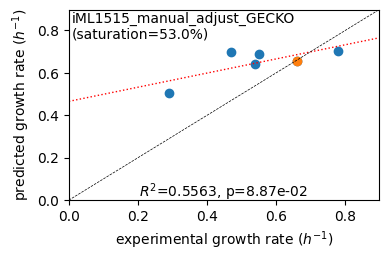

Protein mass fractions:
Acetate                  : r² = 0.0885, p = 7.38e-22 ( 999 proteins lin scale)
Glycerol                 : r² = 0.1254, p = 7.10e-31 ( 999 proteins lin scale)
Fructose                 : r² = 0.2018, p = 8.87e-51 ( 999 proteins lin scale)
Glucose                  : r² = 0.2060, p = 6.32e-52 ( 999 proteins lin scale)
Acetate                  : r² = 0.2887, p = 5.41e-24 ( 302 proteins log scale)
Glycerol                 : r² = 0.3043, p = 2.32e-25 ( 301 proteins log scale)
Fructose                 : r² = 0.3227, p = 1.08e-26 ( 296 proteins log scale)
Glucose                  : r² = 0.3458, p = 4.95e-30 ( 308 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 537.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 514.2 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 309.3 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 204.9 mg/gP predicted
      49

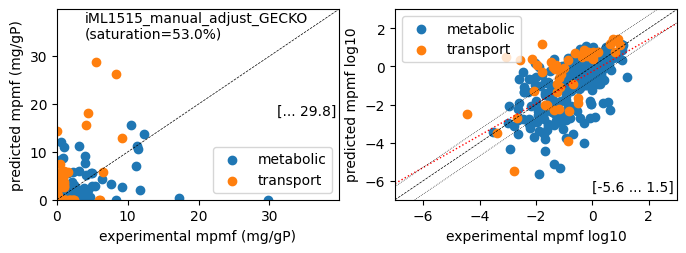

1 file(s) exported for "Load reaction data" into Escher maps


In [11]:
# Optimize model using cobrapy and analyze results
pred_results = {}
for cond, medium in conditions.items():
    with ecm as model:    
        model.medium = medium 
        solution = model.optimize()
        if solution.status == 'optimal':
            gr = solution.objective_value
            pred_results[cond] = solution
            print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
                  f'diff: {gr - exp_grs[cond]:6.3f}')
        else:    
            print(f'{cond} ended with status {solution.status}')

# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')

print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))  
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))

In [12]:
# analyze reactions selected fluxes
rids = ['G6PDH2r', 'EDA', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK']
for rid in rids:
    print(f'{rid:15s}: {df_net_fluxes.at[rid, reference_cond]:8.3f} mmol/gDWh [{df_net_fluxes.at[rid, "gpr"]}]')

G6PDH2r        :    1.135 mmol/gDWh [b1852]
EDA            :    0.000 mmol/gDWh [b1850]
PGI            :    6.630 mmol/gDWh [b4025]
PFK            :    6.817 mmol/gDWh [b1723 or b3916]
FBA            :    6.817 mmol/gDWh [b2097 or b2925]
TPI            :    6.725 mmol/gDWh [b3919]
GAPD           :   13.577 mmol/gDWh [b1779]
PGK            :  -13.577 mmol/gDWh [b2926]
PGM            :  -12.490 mmol/gDWh [b0755 or b3612]
ENO            :   12.490 mmol/gDWh [b2779]
PYK            :    4.183 mmol/gDWh [b1676 or b1854]


## (Optional) Track progress

In [13]:
import scipy
import numpy as np

number = 4
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = er.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Mar 20 20:54:26 2025)
1 table(s) with parameters written to  protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135805,0.204476,999,320
3,iML1515_predicted_GECKO,0.073285,0.284092,999,306
4,iML1515_manual_adjust_GECKO,0.206013,0.345760,999,308


## Closing remarks

By manually adjusting the turnover numbers of seven reactions in glycolysis and the PPP, a substantial flux shift from the PPP to glycolysis can be achieved, thereby enhancing the predictions of protein concentrations in these pathways. Consequently, the overall correlation between predicted and measured protein concentrations has been shown to improve. The adaptation of enzyme-related parameters to known flux distributions and proteomics data emerges as a promising approach to refine our model.

In the subsequent tutorial, we will proceed to enhance our GECKO model through the implementation of an automatic fitting process.

---
---
## (Alternative) gurobipy - manual parameter fitting

The manual fitting of model parameters using the gurobipy interface is nearly equivalent to the modifications applied using cobrapy. However, it should be noted that model contexts are not supported using the gurobipy interface. Consequently, it is necessary to explicitly revert model modifications at the termination of the optimization loop. The function `eo.set_variable_bounds()` updates variable bounds and is employed to modify the total available protein. Consequently, at the termination of the loop, it is necessary to reset the total protein using the aforementioned function. The update of turnover numbers and the creation of the target GECKO model have been demonstrated at step 4 above.

In [14]:
# Load model using gurobipy
fname = os.path.join('SBML_models', f'{baseline_model}.xml')
eo = EcmOptimization(fname)
total_protein = eo.get_variable_bounds('V_PC_total')[1]
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')

SBML model loaded by sbmlxdf: SBML_models/iML1515_predicted_GECKO.xml (Thu Mar 20 20:53:54 2025)
LP Model of iML1515_GECKO
7343 variables, 3372 constraints, 28438 non-zero matrix coefficients
total modeled protein: 306.59 mg/gDW, average saturation level: 0.64


Acetate                  : pred gr: 0.402 h-1 vs. exp 0.290, diff:  0.112
Glycerol                 : pred gr: 0.692 h-1 vs. exp 0.470, diff:  0.222
Fructose                 : pred gr: 0.632 h-1 vs. exp 0.540, diff:  0.092
L-Malate                 : pred gr: 0.679 h-1 vs. exp 0.550, diff:  0.129
Glucose                  : pred gr: 0.650 h-1 vs. exp 0.660, diff: -0.010
Glucose 6-Phosphate      : pred gr: 0.703 h-1 vs. exp 0.780, diff: -0.077


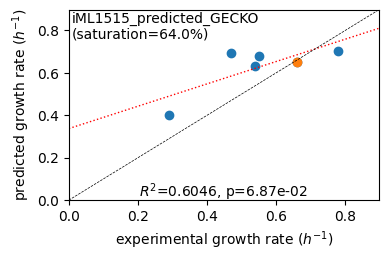

Protein mass fractions:
condition: Glucose
1494 proteins in model with total predicted mass fraction of 495.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 444.5 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 284.8 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 159.7 mg/gP predicted
      495 proteins not measured vs.  51.4 mg/gP predicted
           495 actual  proteins      51.4 mg/gP predicted
total           : r² = 0.1301, p = 4.52e-32 ( 999 proteins lin scale)
 metabolic      : r² = 0.0846, p = 2.56e-16 ( 762 proteins lin scale)
 transport      : r² = 0.4751, p = 9.71e-35 ( 237 proteins lin scale)
total           : r² = 0.3028, p = 1.27e-25 ( 306 proteins log scale)
 metabolic      : r² = 0.3399, p = 1.05e-24 ( 256 proteins log scale)
 transport      : r² = 0.2875, p = 6.00e-05 (  50 proteins log scale)


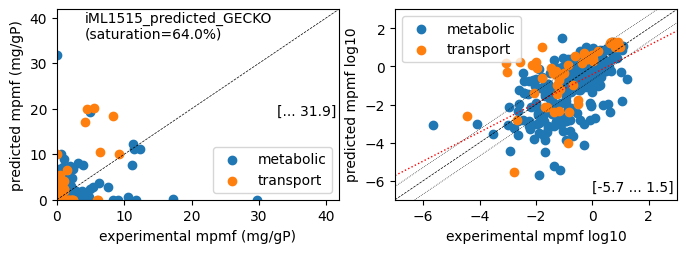

1 file(s) exported for "Load reaction data" into Escher maps


In [15]:
# Optimize model using gurobipy with modified parameters

scale_kcats = {'PGI': 2.0, 'PFK_iso2': 20.0, 'FBA_iso2': 10.0, 'TPI': 20.0, 'ENO': 2.0, 'PGM_iso1_REV': 3.0} 
for rid in scale_kcats:
    if rid not in eo.rdata:
        print(f'{rid:15s} not found')
        raise ValueError 

new_sat_level = .59
orig_bounds = eo.set_variable_bounds({'V_PC_total': (None, total_protein * new_sat_level / sigma)})
eo.scale_kcats(scale_kcats)

pred_results = {}
for cond, medium in conditions.items():
    eo.set_medium(medium)
    solution = eo.optimize()
    if solution.status == 'optimal':
        pred_results[cond] = solution
        gr = solution.objective_value
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')

eo.unscale_kcats()
if orig_bounds:
    eo.set_variable_bounds(orig_bounds)

er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight=reference_cond)

print(f'Protein mass fractions:')
er.report_protein_levels(reference_cond)
er.plot_proteins(reference_cond)  
er.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', f'{baseline_model}_adjusted'))

In [16]:
# analyze reactions selected fluxes
rids = ['G6PDH2r', 'EDA', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK']
for rid in rids:
    print(f'{rid:15s}: {df_net_fluxes.at[rid, reference_cond]:8.3f} mmol/gDWh [{df_net_fluxes.at[rid, "gpr"]}]')

G6PDH2r        :    4.767 mmol/gDWh [b1852]
EDA            :    0.000 mmol/gDWh [b1850]
PGI            :    5.530 mmol/gDWh [b4025]
PFK            :    8.143 mmol/gDWh [b1723 or b3916]
FBA            :    8.143 mmol/gDWh [b2097 or b2925]
TPI            :    8.051 mmol/gDWh [b3919]
GAPD           :   17.443 mmol/gDWh [b1779]
PGK            :  -17.443 mmol/gDWh [b2926]
PGM            :  -16.362 mmol/gDWh [b0755 or b3612]
ENO            :   16.362 mmol/gDWh [b2779]
PYK            :    3.604 mmol/gDWh [b1676 or b1854]


---
---
## References
- Araiza-Olivera, D., Chiquete-Felix, N., Rosas-Lemus, M., Sampedro, J. G., Peña, A., Mujica, A., & Uribe-Carvajal, S. (2013). A glycolytic metabolon in Saccharomyces cerevisiae is stabilized by F-actin. 